In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

In [2]:
project_dir_path = '/n/data1/hms/dbmi/farhat/Roger/gatesMRI/Projects/Biomarkers'

#### Load Packages

In [3]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from collections import Counter
import fastcluster
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as hier

#for exporting to Adobe Illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

Create directory for figures

In [4]:
figures_dir_path = f'{project_dir_path}/Figures/Notebook 7'
if not os.path.exists(figures_dir_path):
    os.makedirs(figures_dir_path)

Specify directory paths

In [5]:
#directory for Pickled Objects
pickled_objects_dir = f'{project_dir_path}/Data/Pickled Files/'

#directory for pooled differential gene expression data
diff_exp_data_dir = f'{project_dir_path}/Data/Pooled Differential Gene Expression/'

Set parameters for plotting

In [6]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=1.0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

### *Function* to extract relevant *diff gene exp* (logFC) dataframe for a set of genes & cluster by genes

In [7]:
def get_diff_exp_matrix(comparison_X, qval_thresh, gene_set):
    
    '''
    This function takes the full concatenated log2FC change matrix for a comparison across all genes (rows) and all datasets (columns) 
    and returns the subset matrix for the input gene set after clustering the genes (rows)
    '''

    #load the matrix with the differential log2FC (that passed q-val & abs(logFC) criteria) for this comparison
    diff_gene_exp_df = pd.read_csv(f'{diff_exp_data_dir}{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv').set_index('Unnamed: 0')

    #subset matrix to genes in gene set
    gene_subset_filter = np.array([gene_id in gene_set for gene_id in diff_gene_exp_df.index])
    diff_gene_exp_subset_df = diff_gene_exp_df[gene_subset_filter]

    #cluster the rows (genes)
    gene_exp_link = fastcluster.linkage(diff_gene_exp_subset_df, method='ward', metric='euclidean')

    #get the new order of the genes
    gene_order = hier.leaves_list(gene_exp_link)

    #re-order the log2FC matrix according to the new clustering order
    reordered_data_subset = diff_gene_exp_subset_df.values[gene_order, :]
    
    return [gene_exp_link, diff_gene_exp_subset_df, reordered_data_subset, gene_order]

### *Function* to plot heatmap of *diff gene exp* (logFC) for a set of genes

In [8]:
def plot_logFC_heatmap_for_gene_subset_and_comparison(comparison_X, qval_thresh, gene_set, gene_set_name):
    
    '''
    This function plots a heatmap given of log2FC across several datasets for a given gene set
    1. comparison group (ATB_v_HC, ATB_v_LTBI, ATB_v_OD)
    2. qval threshold for differential gene expression (0.001, 0.005, 0.01, 0.05)
    3. a list of genes
    '''
    
    #get data matrix & gene link
    gene_exp_link, diff_gene_exp_subset_df, reordered_data_subset, gene_order = get_diff_exp_matrix(comparison_X, qval_thresh, gene_set)

    fig_width_dict = {'ATB_v_HC':1.65, 'ATB_v_LTBI':1.72, 'ATB_v_OD':1.1}
    fig_label_dict = {'ATB_v_HC':'ATB & HC', 'ATB_v_LTBI':'ATB & LTBI', 'ATB_v_OD':'ATB & OD'}
    mpl.rcParams['axes.linewidth'] = 0.35

    num_genes = float(len(gene_set))
    
    if num_genes <= 5:
        height_ratios = [15,num_genes]
        fig_height = 0.15*num_genes
    else:
        height_ratios = [35,45.0/num_genes]
        fig_height = 0.105*num_genes
    
    fig = plt.figure(figsize=(fig_width_dict[comparison_X], fig_height), dpi=300)
    
    gs = GridSpec(2, 2,
               width_ratios=[1.5,10],                
               height_ratios=height_ratios,
               wspace=0.03,
               hspace=1.5/num_genes)

    #DENDROGRAM
    ax2 = fig.add_subplot(gs[0,0], frameon=False)
    Z2 = dendrogram(Z=gene_exp_link, color_threshold=0, above_threshold_color = 'k', leaf_rotation=45, no_labels = True , orientation='left', ax=ax2) # adding/removing the axes
    ax2.set_xticks([])

    #HEATMAP
    axmatrix = fig.add_subplot(gs[0,1])
    abs_max_dataset = np.max( [diff_gene_exp_subset_df.max().max() , abs(diff_gene_exp_subset_df.min().min())] )
    norm = mpl.colors.Normalize(vmin = -1*abs_max_dataset , vmax = abs_max_dataset) #get the normalization
    im = axmatrix.matshow(reordered_data_subset, aspect='auto', origin='lower', cmap=plt.cm.seismic, interpolation='none', norm=norm)

    axmatrix.grid(False)
    axmatrix.tick_params(labelcolor = 'k')
    axmatrix.yaxis.set_label_position("right")
    axmatrix.yaxis.tick_right()

    gene_labels = list(diff_gene_exp_subset_df.index[gene_order])
    axmatrix.set_yticks(range(0,len(gene_labels)))
    axmatrix.set_yticklabels(gene_labels, rotation='0', fontsize = 4.5, color = 'k')
    plt.tick_params(axis = "y", which = "both", left = False, right = True, color = 'k', width = 0.5)

    dataset_labels = list(diff_gene_exp_subset_df.columns)
    axmatrix.set_xticks(range(0,len(dataset_labels)))
    axmatrix.set_xticklabels(dataset_labels, rotation='90', fontsize = 4.5, color = 'k')
    plt.tick_params(axis = "x", which = "both", bottom = False, top = True, color = 'k', width = 0.5)

    #COLORBAR
    ax_cbar = fig.add_subplot(gs[1,1])
    cb2 = mpl.colorbar.ColorbarBase(ax_cbar, cmap=plt.cm.seismic, norm = norm, orientation='horizontal')
    ax_cbar.tick_params(axis = "x", which = "both", bottom = False, top = False, color = 'k', width = 0.5, labelsize = 5)
    ax_cbar.tick_params(axis='x', which='major', pad=-2)
    ax_cbar.set_xlabel(fig_label_dict[comparison_X], fontsize = 5, color = 'k')

    fig.tight_layout()
    file_name = f'{figures_dir_path}/{comparison_X} {gene_set_name}.pdf'
    plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

    plt.show()

## [1] Heatmaps for different gene sets

### [1.1] Top weighted nodes in (1) ATB/HC & ATB/LTBI & ATB/OD networks $(n = 24)$ and (2) ATB/HC & ATB/LTBI networks $(n = 23)$

In [9]:
with open(f'{pickled_objects_dir}Network Files/top weighted node lists/ATB_HC_and_ATB_LTBI_and_ATB_OD.pkl', 'rb') as f:
    top_genes_ATB_HC_and_ATB_LTBI_and_ATB_OD = pickle.load(f)

In [10]:
len(top_genes_ATB_HC_and_ATB_LTBI_and_ATB_OD)

24

In [11]:
with open(f'{pickled_objects_dir}Network Files/top weighted node lists/ATB_HC_and_ATB_LTBI.pkl', 'rb') as f:
    top_genes_ATB_HC_and_ATB_LTBI = pickle.load(f)

In [12]:
len(top_genes_ATB_HC_and_ATB_LTBI)

23

#### combine genes into a *single gene set*

In [13]:
gene_sig_set = top_genes_ATB_HC_and_ATB_LTBI_and_ATB_OD + top_genes_ATB_HC_and_ATB_LTBI

In [14]:
len(gene_sig_set)

47

/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


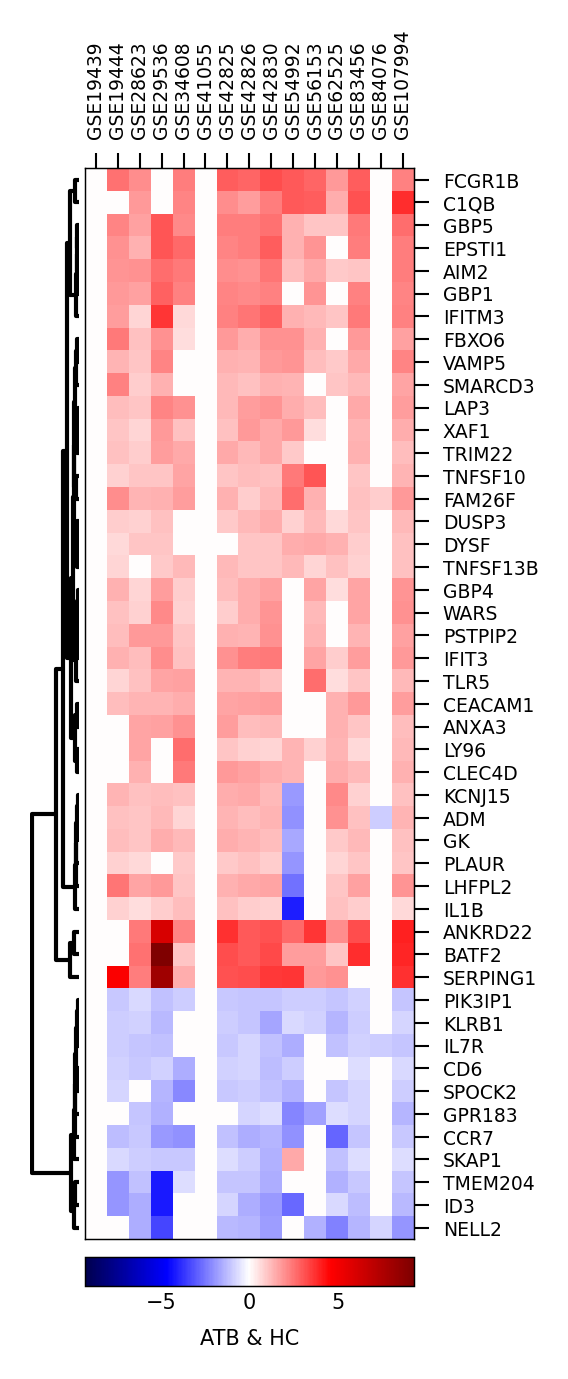

In [15]:
plot_logFC_heatmap_for_gene_subset_and_comparison('ATB_v_HC', '0.05', gene_sig_set, 'top weighted gene sig 47')

/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


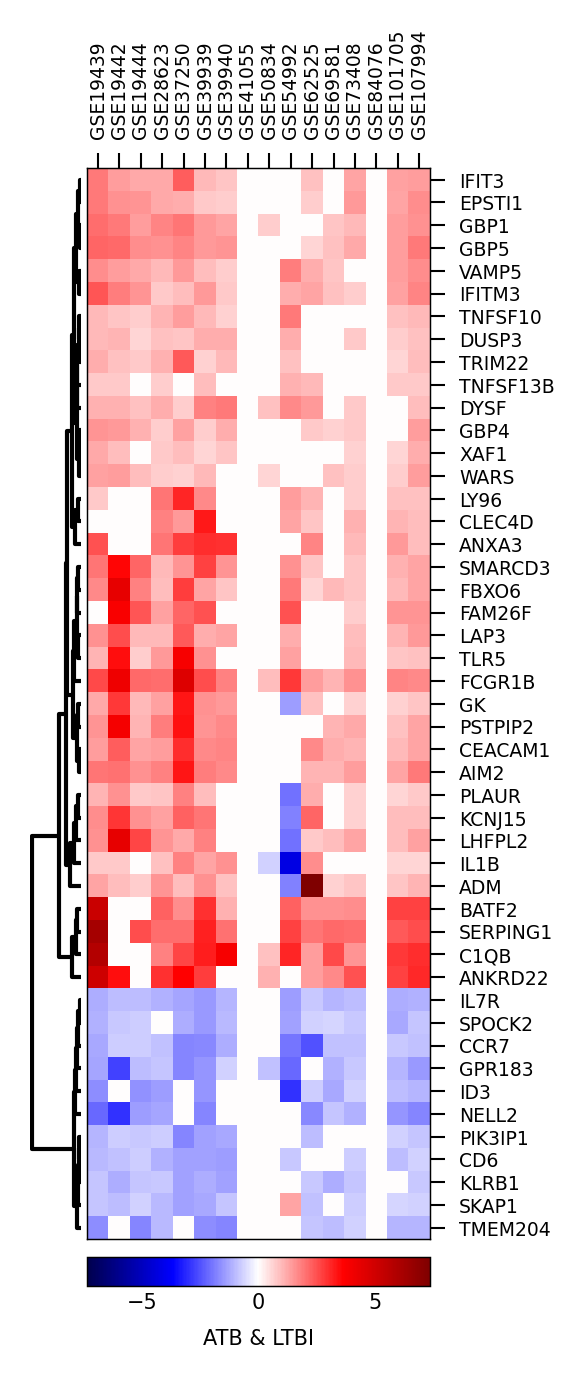

In [16]:
plot_logFC_heatmap_for_gene_subset_and_comparison('ATB_v_LTBI', '0.05', gene_sig_set, 'top weighted gene sig 47')

/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


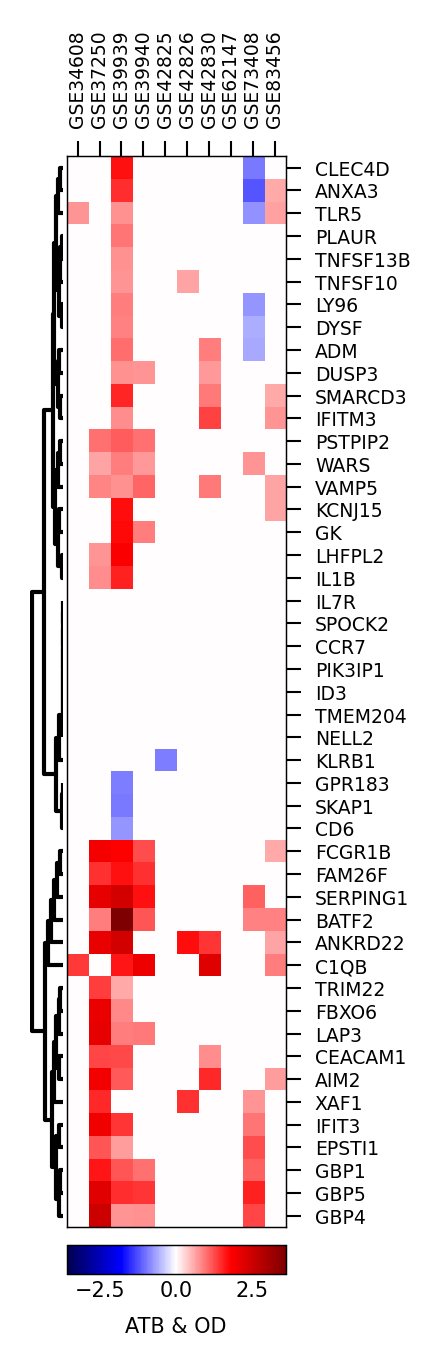

In [17]:
plot_logFC_heatmap_for_gene_subset_and_comparison('ATB_v_OD', '0.05', gene_sig_set, 'top weighted gene sig 47')

### [1.2] Zak 2016 Lancet (16-gene signature)

In [18]:
zak_et_al_2016 = ['ANKRD22','APOL1','BATF2','ETV7','FCGR1A','FCGR1B','GBP1','GBP2','GBP4','GBP5','SCARF1','SEPT4','SERPING1','STAT1','TAP1','TRAFD1']

/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


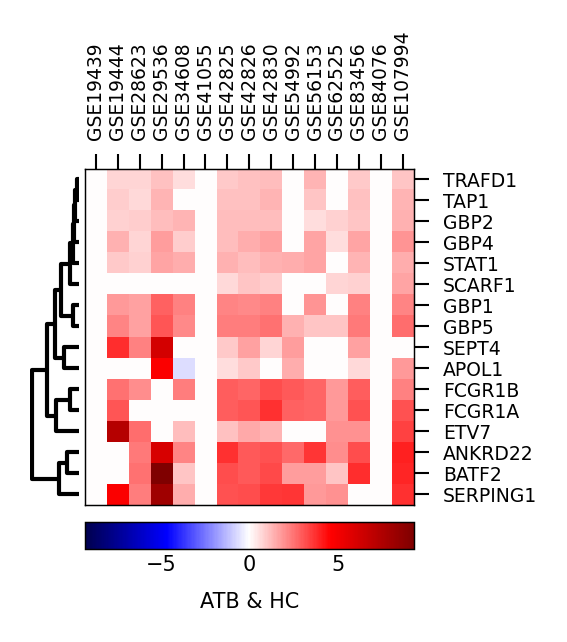

In [19]:
plot_logFC_heatmap_for_gene_subset_and_comparison('ATB_v_HC', '0.05', zak_et_al_2016, 'Zak 2016 Lancet 16')

/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


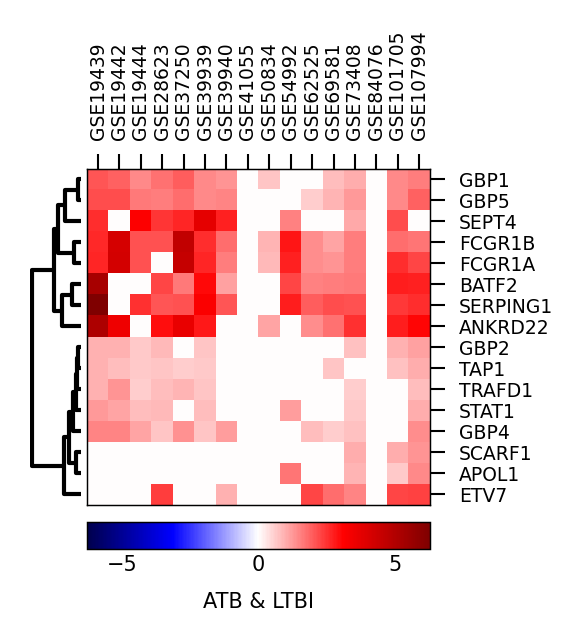

In [20]:
plot_logFC_heatmap_for_gene_subset_and_comparison('ATB_v_LTBI', '0.05', zak_et_al_2016, 'Zak 2016 Lancet 16')

/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


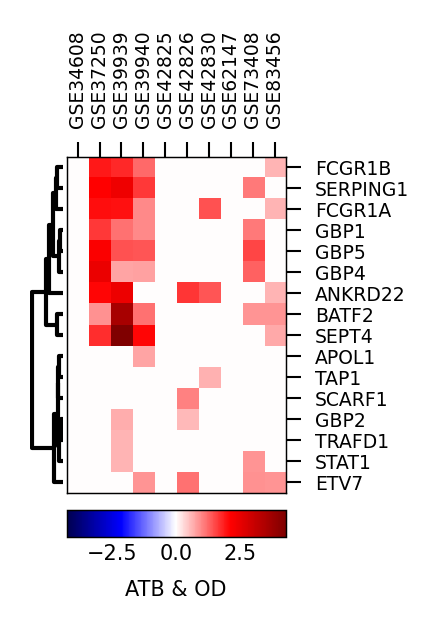

In [21]:
plot_logFC_heatmap_for_gene_subset_and_comparison('ATB_v_OD', '0.05', zak_et_al_2016, 'Zak 2016 Lancet 16')

### [1.3] Sweeney 2016 Lancet Respiratory (3-gene signature)

In [22]:
sweeney_et_al_2016 = ['GBP5','DUSP3','KLF2']

/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


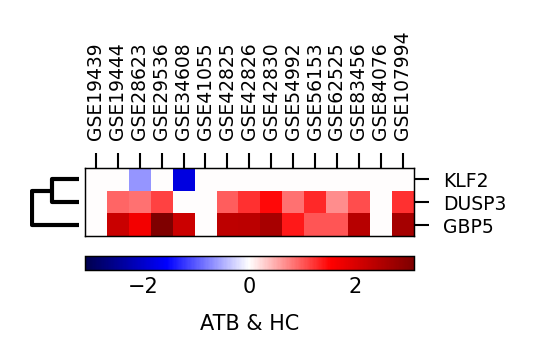

In [23]:
plot_logFC_heatmap_for_gene_subset_and_comparison('ATB_v_HC', '0.05', sweeney_et_al_2016, 'Sweeney 2016 Lancet Respiratory 3')

/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


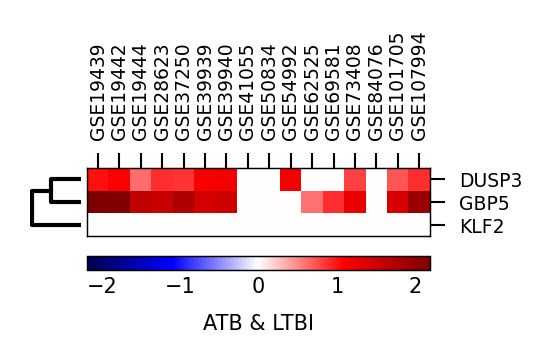

In [24]:
plot_logFC_heatmap_for_gene_subset_and_comparison('ATB_v_LTBI', '0.05', sweeney_et_al_2016, 'Sweeney 2016 Lancet Respiratory 3')

/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


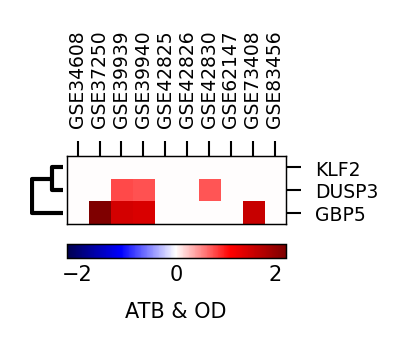

In [25]:
plot_logFC_heatmap_for_gene_subset_and_comparison('ATB_v_OD', '0.05', sweeney_et_al_2016, 'Sweeney 2016 Lancet Respiratory 3')

### [1.4] Sambarey 2016 EBioMedicine (10-gene signature)

In [26]:
sambarey_et_al_2016 = ['FCGR1A','HK3','RAB13','RBBP8','IFI44L','TIMM10','BCL6','SMARCD3','CYP4F3','SLPI']

/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


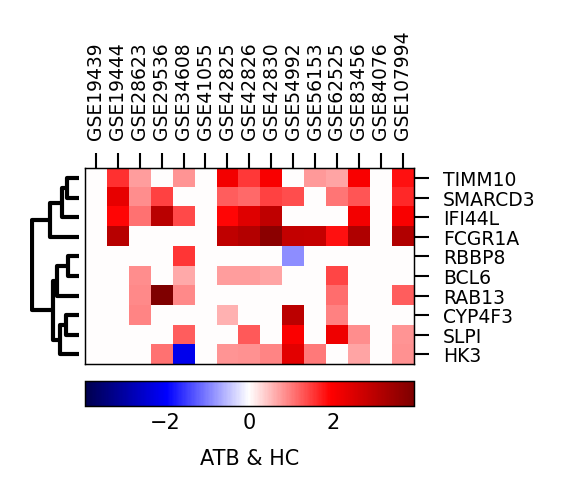

In [27]:
plot_logFC_heatmap_for_gene_subset_and_comparison('ATB_v_HC', '0.05', sambarey_et_al_2016, 'Sambarey 2016 EBioMedicine 10')

/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


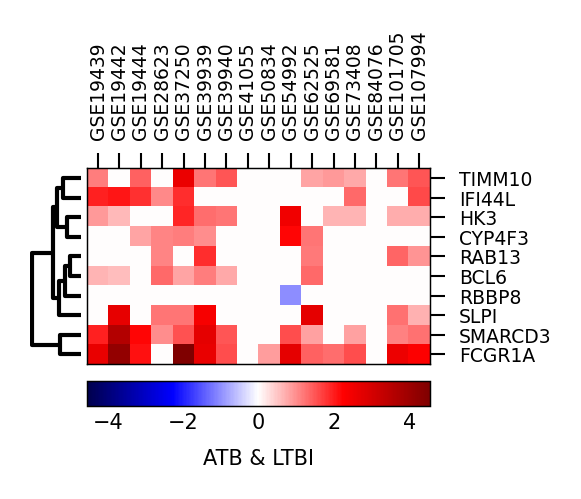

In [28]:
plot_logFC_heatmap_for_gene_subset_and_comparison('ATB_v_LTBI', '0.05', sambarey_et_al_2016, 'Sambarey 2016 EBioMedicine 10')

/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


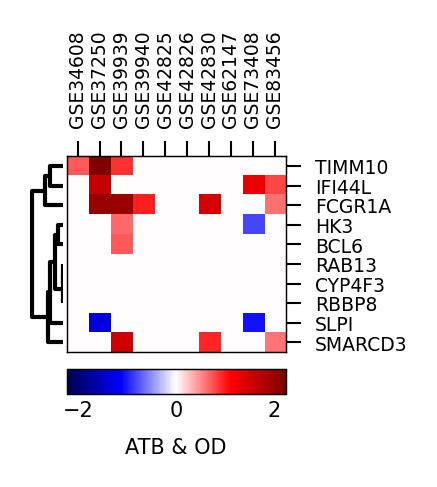

In [29]:
plot_logFC_heatmap_for_gene_subset_and_comparison('ATB_v_OD', '0.05', sambarey_et_al_2016, 'Sambarey 2016 EBioMedicine 10')

### [1.5] 19/47 gene set from running 47 genes in Elastic Net on Drug Treatment (GSE40553) data

In [30]:
gene_signature_from_elastic_net = ['SMARCD3', 'IFITM3', 'BATF2', 'VAMP5', 'WARS', 'FCGR1B', 'ADM', 'EPSTI1', 'GBP5', 'LAP3', 'GBP1', 'LHFPL2', 'CD6', 'KLRB1', 'PIK3IP1', 'CCR7', 'IL7R', 'DYSF', 'TNFSF13B']

/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


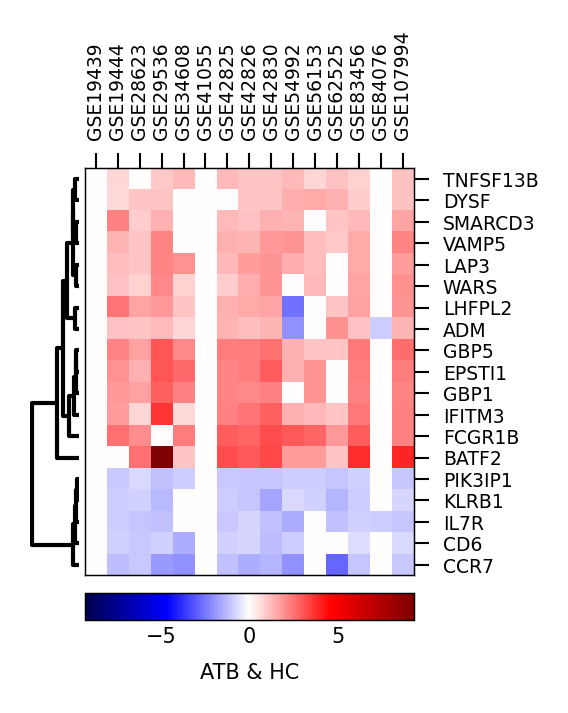

In [31]:
plot_logFC_heatmap_for_gene_subset_and_comparison('ATB_v_HC', '0.05', gene_signature_from_elastic_net, 'top weighted gene sig after Elastic Net 19')

/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


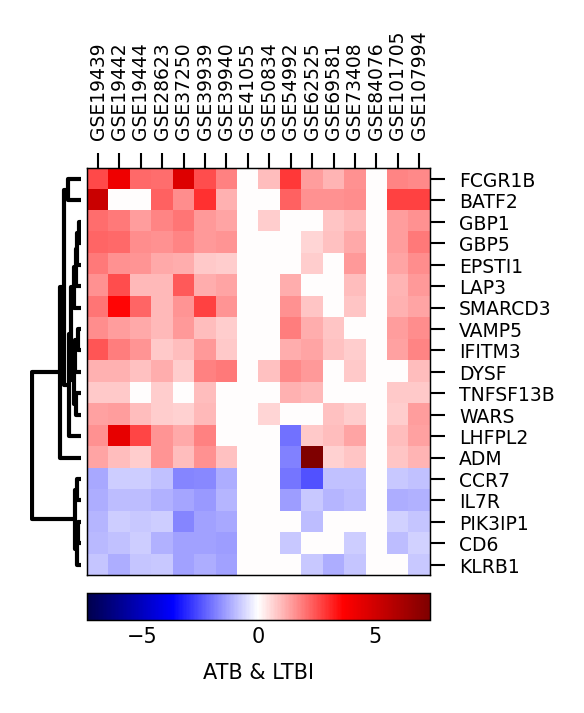

In [32]:
plot_logFC_heatmap_for_gene_subset_and_comparison('ATB_v_LTBI', '0.05', gene_signature_from_elastic_net, 'top weighted gene sig after Elastic Net 19')

/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


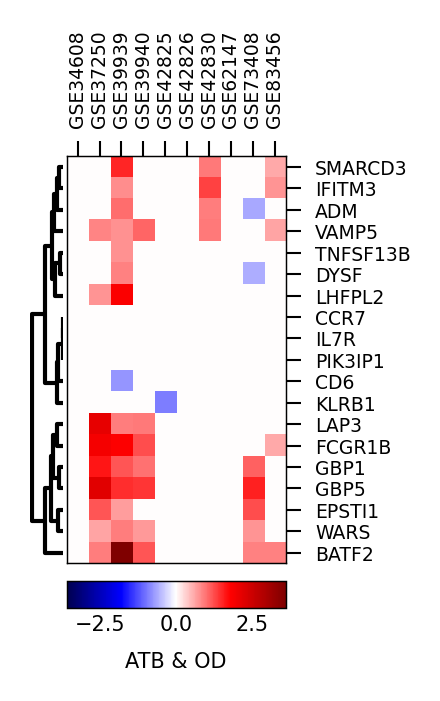

In [33]:
plot_logFC_heatmap_for_gene_subset_and_comparison('ATB_v_OD', '0.05', gene_signature_from_elastic_net, 'top weighted gene sig after Elastic Net 19')